# Simple chord classification

The task is to classify chords (or more precisely pitch class sets) based on chromagram features.

We use a single Beatles song with just two chord and silence.

The task is in fact multilabel classification, since each pitch class is generally independent.

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import keras

Populating the interactive namespace from numpy and matplotlib


## Data loading

In [21]:
labels_file = 'data/beatles/chord-pcs/4096_2048/The_Beatles/01_-_Please_Please_Me/08_-_Love_Me_Do.pcs'
features_file = 'data/beatles/chromagram/block=4096_hop=2048_bins=-48,67_div=1/The_Beatles/01_-_Please_Please_Me/08_-_Love_Me_Do.npz'

In [331]:
df_labels = pd.read_csv(labels_file, sep='\t')
df_labels.head(15)

,label,C,Db,D,Eb,E,F,Gb,G,Ab,A,Bb,B
0,N,0,0,0,0,0,0,0,0,0,0,0,0
1,N,0,0,0,0,0,0,0,0,0,0,0,0
2,N,0,0,0,0,0,0,0,0,0,0,0,0
3,N,0,0,0,0,0,0,0,0,0,0,0,0
4,N,0,0,0,0,0,0,0,0,0,0,0,0
5,N,0,0,0,0,0,0,0,0,0,0,0,0
6,N,0,0,0,0,0,0,0,0,0,0,0,0
7,N,0,0,0,0,0,0,0,0,0,0,0,0
8,N,0,0,0,0,0,0,0,0,0,0,0,0
9,G,0,0,1,0,0,0,0,1,0,0,0,1


In [485]:
labels_pcs = df_labels[df_labels.columns[1:]].as_matrix()
labels_pcs[:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]])

In [24]:
data = np.load(features_file)

In [28]:
features = data['X']
times = data['times']

## Data exploration

In [29]:
features.shape

(3075, 115)

In [31]:
times.shape

(3075,)

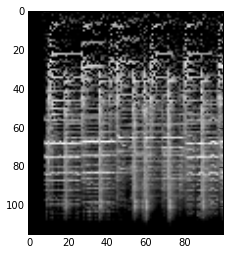

In [41]:
imshow(features[:100].T, cmap='gray');

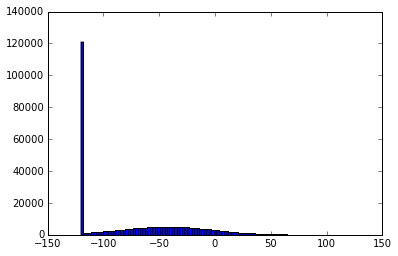

In [43]:
hist(features.flatten(), 100);

In [988]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(features).astype('float32')

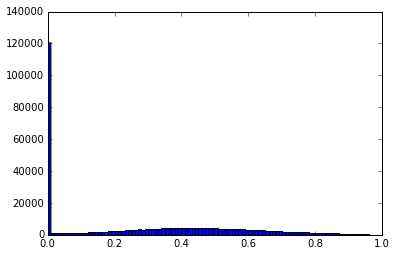

In [990]:
plt.hist(X.flatten(), 100);

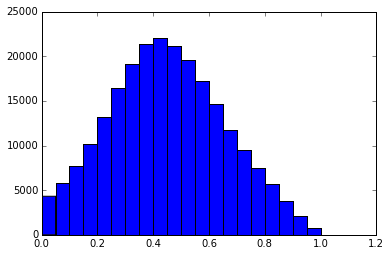

In [52]:
# non-zero values
hist(X[X > 0].flatten(), 20);

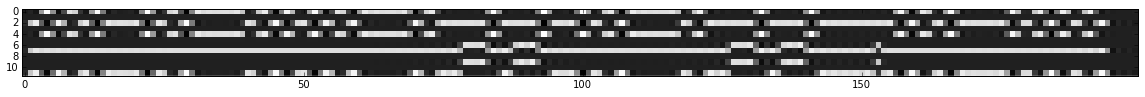

In [530]:
import scipy.signal
def plot_labels(l, fifths=False, resample=True):
    figure(figsize=(20,5))
    if fifths:
        l = l[:,np.arange(12)*7 % 12]
    l = l.T
    if resample:
        l = scipy.signal.resample(l, 200, axis=1)
    imshow(l, cmap='gray', interpolation='none')

plot_labels(labels_pcs)

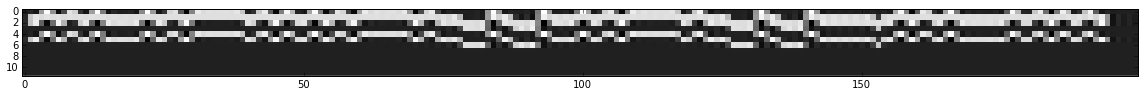

In [496]:
plot_labels(labels_pcs, fifths=True)

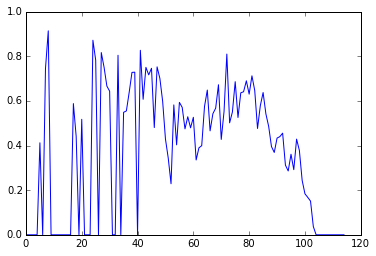

In [241]:
plot(X[500]);

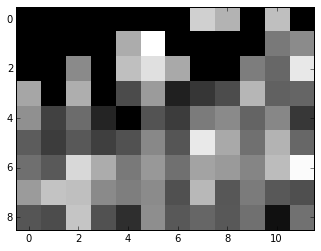

In [240]:
imshow(X[100,:108].reshape(-1,12), cmap='gray', interpolation='nearest');

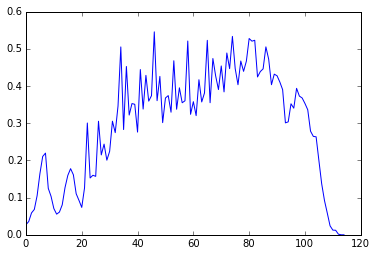

In [243]:
plot(X.mean(axis=0));

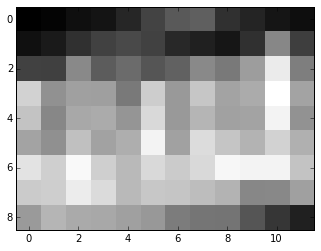

In [249]:
imshow(X.mean(axis=0)[:108].reshape(-1,12), cmap='gray', interpolation='nearest');

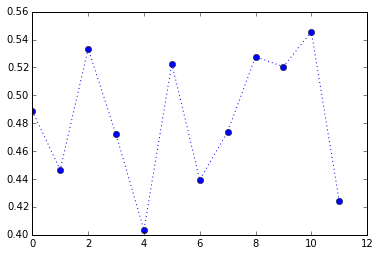

In [248]:
plot(X.mean(axis=0)[:108].reshape(-1,12).max(axis=0), 'o:');

## Data preparation

In [656]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
label_dict = dict((c,i) for (i, c) in enumerate(sorted(df_labels['label'].drop_duplicates())))
label_classes = df_labels['label'].apply(lambda l: label_dict[l]).as_matrix().reshape(-1, 1)
n_classes = len(label_dict)
label_ohe = OneHotEncoder(n_values=n_classes)
labels_ohe = label_ohe.fit_transform(label_classes).toarray().astype(np.int32)
labels_ohe

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ..., 
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=int32)

In [991]:
from sklearn.cross_validation import train_test_split
ix_train, ix_test = train_test_split(np.arange(len(X)), test_size=0.2, random_state=42)
ix_train, ix_valid = train_test_split(ix_train, test_size=0.2/(1-0.2), random_state=42)
X_train, X_valid, X_test = X[ix_train], X[ix_valid], X[ix_test]
y_train, y_valid, y_test = labels_pcs[ix_train], labels_pcs[ix_valid], labels_pcs[ix_test]
y_ohe_train, y_ohe_valid, y_ohe_test = labels_ohe[ix_train], labels_ohe[ix_valid], labels_ohe[ix_test]
y_cls_train, y_cls_valid, y_cls_test = label_classes[ix_train], label_classes[ix_valid], label_classes[ix_test]

In [992]:
for d in [X_train, X_valid, X_test, y_train, y_valid, y_test]:
    print(d.shape)

(1845, 115)
(615, 115)
(615, 115)
(1845, 12)
(615, 12)
(615, 12)


In [471]:
y_ohe_train[:10]

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0]], dtype=int32)

In [470]:
y_train[:10]

array([[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]])

## Training classifiers

### Baseline performance - dummy classifier

For this data the multi-class problem is easier.

#### Multi-label

training score: 0.0433604336043
validation score: 0.0406504065041


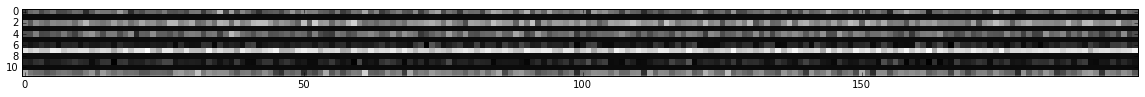

In [473]:
from sklearn.dummy import DummyClassifier
dummy_classifier = DummyClassifier()
dummy_classifier.fit(X_train, y_train)
print('training score:', dummy_classifier.score(X_train, y_train))
print('validation score:', dummy_classifier.score(X_valid, y_valid))
plot_labels(dummy_classifier.predict(features))

#### Multi-class (one-hot encoding)

training score: 0.188617886179
validation score: 0.19512195122


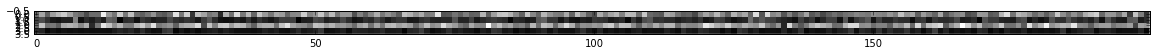

In [474]:
from sklearn.dummy import DummyClassifier
dummy_classifier_ohe = DummyClassifier()
dummy_classifier_ohe.fit(X_train, y_one_train)
print('training score:', dummy_classifier_ohe.score(X_train, y_ohe_train))
print('validation score:', dummy_classifier_ohe.score(X_valid, y_ohe_valid))
plot_labels(dummy_classifier_ohe.predict(features))

### Logistic regression

#### Multi-label

In [1176]:
from sklearn.metrics import hamming_loss, accuracy_score 

def model_report_multilabel(model_predict, X_train, y_train, X_valid, y_valid):
    def report_dataset(X, y_true, title):
        y_pred = model_predict(X)
        print(title + ' accuracy (exatch match):', accuracy_score(y_true, y_pred))
        print(title + ' hamming score (non-exatch match):', 1 - hamming_loss(y_true, y_pred))

    report_dataset(X_train, y_train, 'training')
    report_dataset(X_valid, y_valid, 'validation')

In [1177]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

log_reg = OneVsRestClassifier(LogisticRegression())
log_reg.fit(X_train, y_train)

print('training score:', log_reg.score(X_train, y_train))
print('validation score:', log_reg.score(X_valid, y_valid))

model_report_multilabel(log_reg.predict, X_train, y_train, X_valid, y_valid)

/Users/bzamecnik/anaconda/lib/python3.4/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/Users/bzamecnik/anaconda/lib/python3.4/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/Users/bzamecnik/anaconda/lib/python3.4/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 5 is present in all training examples.
  str(classes[c]))
/Users/bzamecnik/anaconda/lib/python3.4/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 8 is present in all training examples.
  str(classes[c]))
/Users/bzamecnik/anaconda/lib/python3.4/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 10 is present in all training examples.
  str(classes[c]))


training score: 0.773983739837
validation score: 0.765853658537
training accuracy (exatch match): 0.773983739837
training hamming score (non-exatch match): 0.9481481481481482
validation accuracy (exatch match): 0.765853658537
validation hamming score (non-exatch match): 0.9449864498644986


It seems that score for OneVsRestClassifier + LogisticRegression is the same as accuracy score.

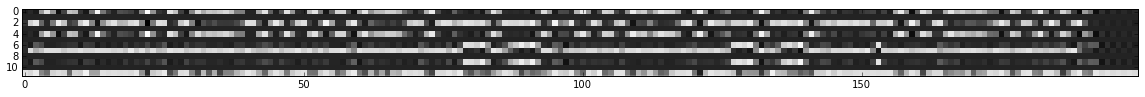

In [478]:
plot_labels(log_reg.predict(features))

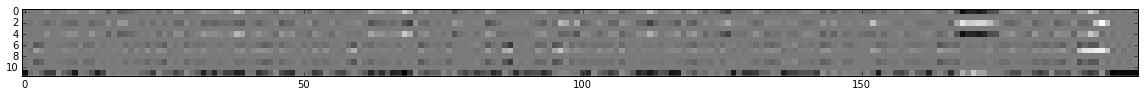

In [499]:
plot_labels(labels_pcs - log_reg.predict(features))

In [149]:
import scipy
scipy.misc.imsave('log_reg.png', log_reg.predict(features).T)

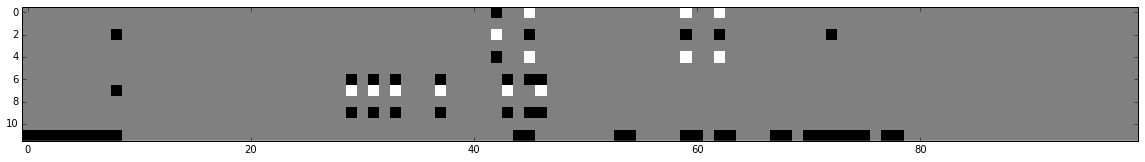

In [536]:
plot_labels(labels_pcs[:100] - log_reg.predict(features[:100]), resample=False)

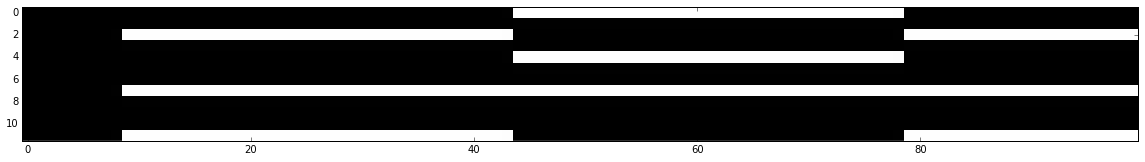

In [533]:
plot_labels(labels_pcs[:100], resample=False)

#### Multi-class

In [555]:
log_reg_ohe = OneVsRestClassifier(LogisticRegression(multi_class='multinomial', solver='lbfgs'))
log_reg_ohe.fit(X_train, y_ohe_train)

print('training score:', log_reg_ohe.score(X_train, y_ohe_train))
print('validation score:', log_reg_ohe.score(X_valid, y_ohe_valid))

# model_report_multilabel(log_reg_ohe.predict)

training score: 0.788075880759
validation score: 0.778861788618


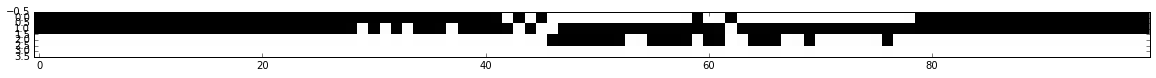

In [559]:
plot_labels(log_reg_ohe.predict(features[:100]), resample=False)

In [560]:
log_reg_ohe.predict(features[:10])

array([[0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 1]])

## Support vector machine

In [276]:
from sklearn.svm import SVC
svc = OneVsRestClassifier(SVC())
svc.fit(X_train, y_train)
print('training score:', svc.score(X_train, y_train))
print('validation score:', svc.score(X_valid, y_valid))

/Users/bzamecnik/anaconda/lib/python3.4/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/Users/bzamecnik/anaconda/lib/python3.4/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/Users/bzamecnik/anaconda/lib/python3.4/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 5 is present in all training examples.
  str(classes[c]))
/Users/bzamecnik/anaconda/lib/python3.4/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 8 is present in all training examples.
  str(classes[c]))


training score: 0.644444444444
validation score: 0.652032520325


/Users/bzamecnik/anaconda/lib/python3.4/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 10 is present in all training examples.
  str(classes[c]))


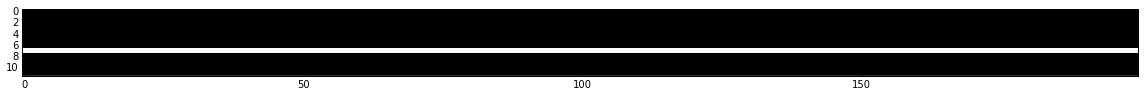

In [277]:
plot_labels(svc.predict(features))

## Neural nets

In [1178]:
def conv_reshape(X):
    return X.reshape(X.shape[0], X.shape[1], 1)

X_conv_train = conv_reshape(X_train)
X_conv_valid = conv_reshape(X_valid)

#### Notes

- the last layer has to be sigmoid, not softmax
  - since each output label should be independent a multiple can be active at the same time
- very sparse inputs can easily saturate sigmoid activation if it's near the first layer
- class_mode='binary' for multi-label classification
- predict_classes() then returns a binary vector
- loss: MAE or binary_crossentropy?
  - why binary_crossentropy gives worse accuracy than MAE?
  - binary_crossentropy works ok
- problems with loss going to NAN after the first training iteration
  - optimizer clipnorm doesn't help
  - BatchNormalization doesn't help
    - BatchNormalization between convolution and activation works
- BatchNormalization might be useful
- be aware to use scaled inputs, not raw ones

In [1065]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization

In [ ]:
# working model
# results after 150 epochs:
# - validation accuracy (exatch match): 0.79837398374
# - validation hamming score (non-exatch match): 0.9456639566395664
model = Sequential()
model.add(Dense(50, input_dim=features.shape[1]))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(12))
model.add(Activation('sigmoid'))

print('number of parameters:', model.count_params())
print('weights', [w.shape for w in model.get_weights()])

model.compile(class_mode='binary', loss='binary_crossentropy', optimizer='adadelta')

In [ ]:
# working example with convolutional layers:

# results after 100 epochs:
# training accuracy (exatch match): 0.810298102981
# training hamming score (non-exatch match): 0.9575880758807588
# validation accuracy (exatch match): 0.767479674797
# validation hamming score (non-exatch match): 0.9387533875338754

# number of parameters: 8552
# weights [(5, 1, 5, 1), (5,), (111, 5), (111, 5), (111, 5), (111, 5), (10, 5, 5, 1), (10,), (51, 10), (51, 10), (51, 10), (51, 10), (510, 12), (12,)]

model = Sequential()
model.add(Convolution1D(5, 5, input_shape=(features.shape[1], 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(2, 2))
model.add(Convolution1D(10, 5))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(12))
model.add(Activation('sigmoid'))

model.compile(class_mode='binary', loss='binary_crossentropy', optimizer='adam')

In [ ]:
# one more dense layer:

# 100 epochs
# training accuracy (exatch match): 0.931707317073
# training hamming score (non-exatch match): 0.984914182475158
# validation accuracy (exatch match): 0.827642276423
# validation hamming score (non-exatch match): 0.9470189701897019

# number of parameters: 54732
# weights [(5, 1, 5, 1), (5,), (111, 5), (111, 5), (111, 5), (111, 5), (10, 5, 5, 1), (10,), (51, 10), (51, 10), (51, 10), (51, 10), (510, 100), (100,), (100, 12), (12,)]

model = Sequential()
model.add(Convolution1D(5, 5, input_shape=(features.shape[1], 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(2, 2))
model.add(Convolution1D(10, 5))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(12))
model.add(Activation('sigmoid'))

print('number of parameters:', model.count_params())
print('weights', [w.shape for w in model.get_weights()])

model.compile(class_mode='binary', loss='binary_crossentropy', optimizer='adam')

In [ ]:
# more convolution filters, more smaller dense layers at the end

# number of parameters: 14702
# weights [(10, 1, 5, 1), (10,), (111, 10), (111, 10), (111, 10), (111, 10), (10, 10, 5, 1), (10,), (51, 10), (51, 10), (51, 10), (51, 10), (510, 20), (20,), (20, 20), (20,), (20, 12), (12,)]
# 100 epochs

# last lost: 0.0493504540061
# training accuracy (exatch match): 0.918699186992
# training hamming score (non-exatch match): 0.9811201445347787
# validation accuracy (exatch match): 0.827642276423
# validation hamming score (non-exatch match): 0.9518970189701897

model = Sequential()

model.add(Convolution1D(10, 5, input_shape=(features.shape[1], 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling1D(2, 2))

model.add(Convolution1D(10, 5))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(20))
model.add(Activation('relu'))

model.add(Dense(20))
model.add(Activation('relu'))

model.add(Dense(12))
model.add(Activation('sigmoid'))

model.compile(class_mode='binary', loss='binary_crossentropy', optimizer='adam')

In [ ]:
# max-pooling after the two convolutions

# number of parameters: 16522
# weights [(10, 1, 3, 1), (10,), (113, 10), (113, 10), (113, 10), (113, 10), (10, 10, 3, 1), (10,), (111, 10), (111, 10), (111, 10), (111, 10), (550, 20), (20,), (20, 20), (20,), (20, 12), (12,)]
# 100 epochs

# last loss: 0.0579237073095

# training accuracy (exatch match): 0.919241192412
# training hamming score (non-exatch match): 0.9795392953929539
# validation accuracy (exatch match): 0.834146341463
# validation hamming score (non-exatch match): 0.9521680216802169

model = Sequential()

model.add(Convolution1D(10, 3, input_shape=(features.shape[1], 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution1D(10, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling1D(2, 2))

model.add(Flatten())

model.add(Dense(20))
model.add(Activation('relu'))

model.add(Dense(20))
model.add(Activation('relu'))

model.add(Dense(12))
model.add(Activation('sigmoid'))

print('number of parameters:', model.count_params())
print('weights', [w.shape for w in model.get_weights()])

model.compile(class_mode='binary', loss='binary_crossentropy', optimizer='adam')

In [1363]:
model = Sequential()

model.add(Convolution1D(10, 3, input_shape=(features.shape[1], 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution1D(10, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling1D(2, 2))

model.add(Flatten())

model.add(Dense(20))
model.add(Activation('relu'))

model.add(Dense(20))
model.add(Activation('relu'))

model.add(Dense(12))
model.add(Activation('sigmoid'))

print('number of parameters:', model.count_params())
print('weights', [w.shape for w in model.get_weights()])

model.compile(class_mode='binary', loss='binary_crossentropy', optimizer='adam')

number of parameters: 16522
weights [(10, 1, 3, 1), (10,), (113, 10), (113, 10), (113, 10), (113, 10), (10, 10, 3, 1), (10,), (111, 10), (111, 10), (111, 10), (111, 10), (550, 20), (20,), (20, 20), (20,), (20, 12), (12,)]


In [1364]:
hist = model.fit(X_conv_train, y_train, nb_epoch=100)
# hist = model.fit(X_train, y_train, nb_epoch=100)

Epoch 1/100
1845/1845 [==============================] - 1s - loss: 0.6832     
Epoch 2/100
1845/1845 [==============================] - 0s - loss: 0.6374     
Epoch 3/100
1845/1845 [==============================] - 0s - loss: 0.4797     
Epoch 4/100
1845/1845 [==============================] - 0s - loss: 0.3638     
Epoch 5/100
1845/1845 [==============================] - 0s - loss: 0.3277     
Epoch 6/100
1845/1845 [==============================] - 0s - loss: 0.3127     
Epoch 7/100
1845/1845 [==============================] - 0s - loss: 0.3031     
Epoch 8/100
1845/1845 [==============================] - 0s - loss: 0.2934     
Epoch 9/100
1845/1845 [==============================] - 0s - loss: 0.2806     
Epoch 10/100
1845/1845 [==============================] - 1s - loss: 0.2645     
Epoch 11/100
1845/1845 [==============================] - 1s - loss: 0.2478     
Epoch 12/100
1845/1845 [==============================] - 1s - loss: 0.2317     
Epoch 13/100
1845/1845 [=============

0.0579237073095


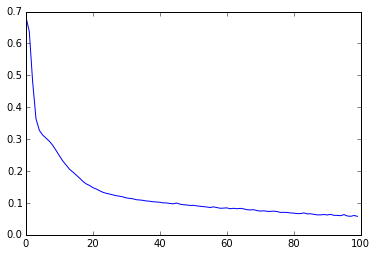

In [1365]:
losses = hist.history['loss']
print('last loss:', losses[-1])
plot(losses);

In [1366]:
model_report_multilabel(model.predict_classes, X_conv_train, y_train, X_conv_valid, y_valid)

1845/1845 [==============================] - 0s     
training accuracy (exatch match): 0.919241192412
training hamming score (non-exatch match): 0.9795392953929539
615/615 [==============================] - 0s     
validation accuracy (exatch match): 0.834146341463
validation hamming score (non-exatch match): 0.9521680216802169


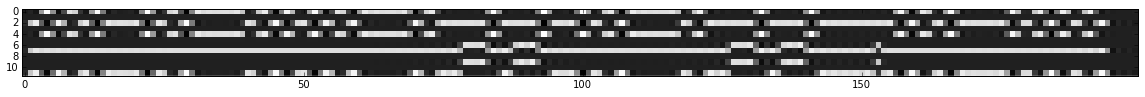

In [1368]:
# true labels
plot_labels(labels_pcs)

3075/3075 [==============================] - 0s     


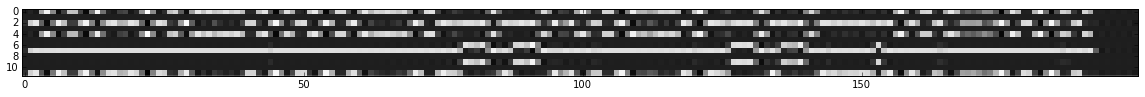

In [1367]:
# predicted labels
labels_pred_full = model.predict_classes(conv_reshape(X))
plot_labels(labels_pred_full)

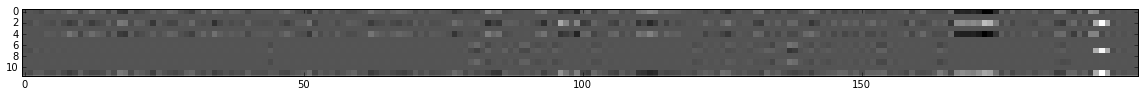

In [1370]:
# difference
plot_labels(labels_pcs - labels_pred_full)

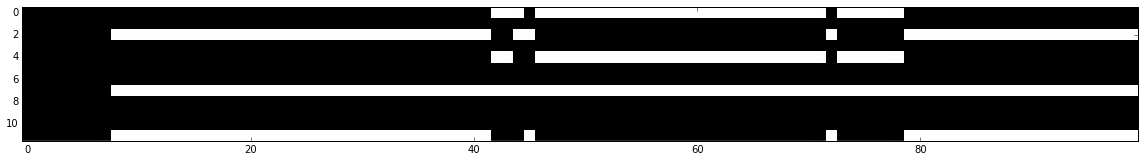

In [1371]:
plot_labels(labels_pred_full[:100], resample=False)

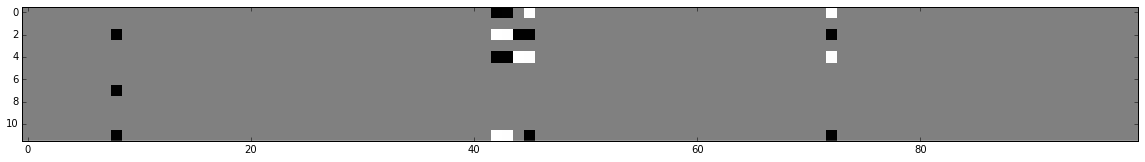

In [1372]:
plot_labels(labels_pcs[:100] - labels_pred_full[:100], resample=False)